# SARIMAX

- **S**easonal **ARIMA** with e**X**ogenous regressors
- one **SARIMAX** model per zone
- seasonal period: m=144 daily pattern
- exogenous features: Temperature, Humidity, Wind Speed, general diffuse flows, diffuse flows

### import libraries

In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(".."))

from common.load_data import load_data
from common.time_based_features import add_time_based_features
from common.chronological_split import chronological_train_test_split

[INFO] Using 'DateTime' as datetime index column
Train period: 2017-01-01 00:00:00 to 2017-10-19 04:30:00
Test period: 2017-10-19 04:40:00 to 2017-12-30 23:50:00


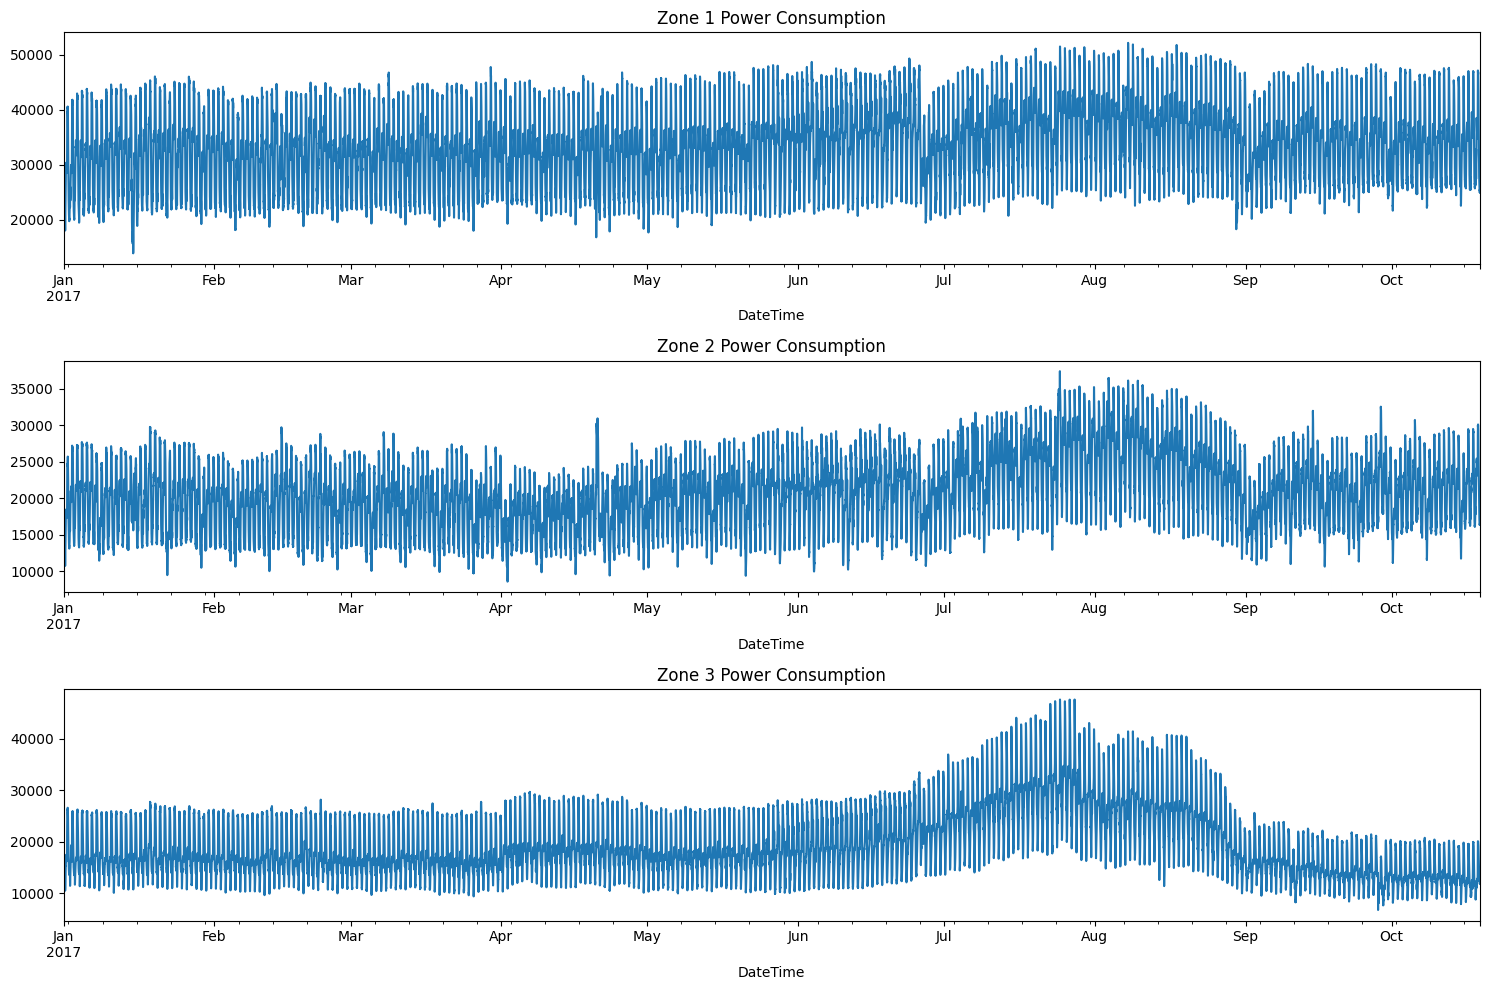

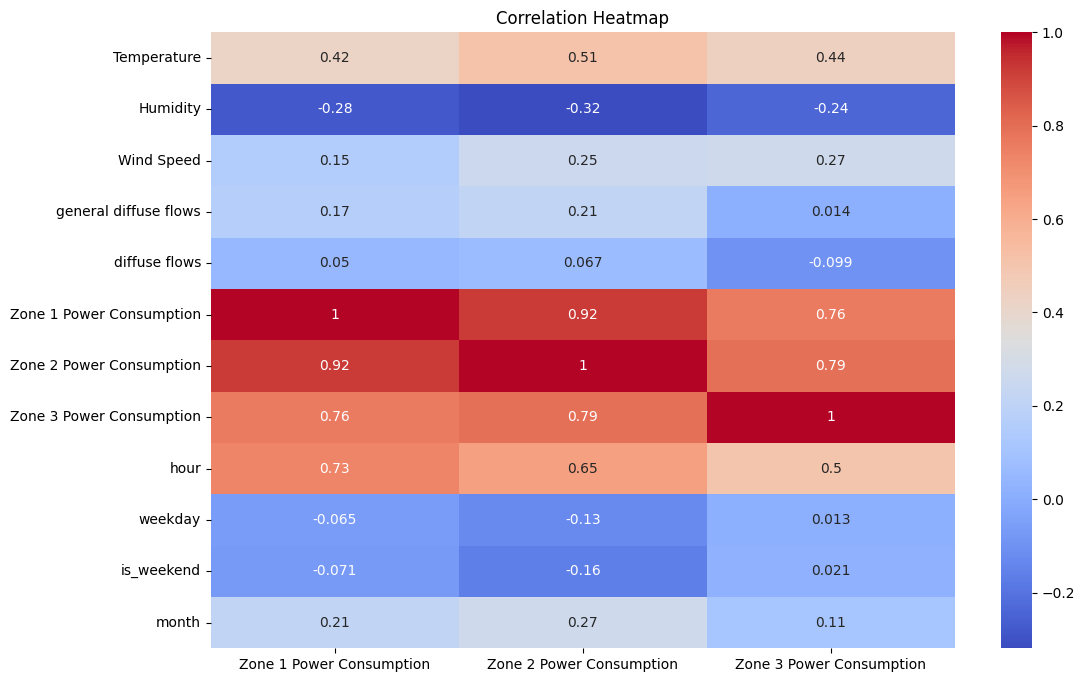

In [25]:
from concurrent.futures import ProcessPoolExecutor
from common.sarimax import sarimax_fast
from functools import partial
# -------------------------------
# 1. Load and preprocess
# -------------------------------
# Load and preprocess data
dataset = (
    load_data(file_path='..\Data\Tetuan City power consumption.csv')
    .pipe(add_time_based_features)
)


# Chronological split
dataset_train, dataset_test = chronological_train_test_split(dataset, split_ratio=0.8)

# Ensure proper chronological split
print(f"Train period: {dataset_train.index.min()} to {dataset_train.index.max()}")
print(f"Test period: {dataset_test.index.min()} to {dataset_test.index.max()}")

# Verify no overlap
assert dataset_train.index.max() < dataset_test.index.min(), "Data leakage detected - test period starts before train period ends"


zones = [
    'Zone 1 Power Consumption',
    'Zone 2 Power Consumption',
    'Zone 3 Power Consumption'
]

# Plot power consumption patterns
plt.figure(figsize=(15, 10))
i = 1
for zone in zones:
    plt.subplot(3, 1, i)
    i += 1
    dataset_train[zone].plot(title=zone)    

plt.tight_layout()
plt.show()

# Examine correlations
corr_matrix = dataset_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['Zone 1 Power Consumption', 
                        'Zone 2 Power Consumption',
                        'Zone 3 Power Consumption']], 
            annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()




#### Key findings
- **Strong Temporal Patterns**:
  - Hour has very high correlation with power consumption (0.73 for Zone 1, 0.65 for Zone 2)
  - This confirms daily cycles are crucial for modeling
- **Weather Impact**:
  - Temperature shows moderate correlation (0.42-0.51 across zones)
  - Humidity shows negative correlation (-0.24 to -0.32)
  - Wind speed has weaker but notable correlation (0.15-0.27)
- **Zone Relationships**:
  - Zones are highly correlated with each other (0.76-0.92)
  - Suggests potential for multivariate modeling or using other zones as features
- **Unexpected Findings**:
  - Diffuse flows show minimal correlation with consumption
  - Weekday/weekend indicators show weak relationships

### Create Features

In [26]:
def create_features(df):
    """Feature engineering applied consistently to train and test sets"""
    df = df.copy()
    
    # Cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    
    # Weather interactions
    df['temp_humidity'] = df['Temperature'] * df['Humidity']
    
    # Time-based flags
    df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)
    
    return df

In [30]:
# Apply to both sets
#dataset_train_fe = create_features(dataset_train)
#dataset_test_fe = create_features(dataset_test)

# Remove low-correlation features
low_corr_features = ['general diffuse flows', 'diffuse flows', 'weekday']
dataset_train_fe = dataset_train.drop(columns=low_corr_features)
dataset_test_fe = dataset_test.drop(columns=low_corr_features)

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings  # Added missing import

def correct_sarimax(zone, train, test, exog_vars):
    """
    Proper SARIMAX implementation with:
    - Correct time-varying regression setup
    - Maintained train/test separation
    - Robust error handling
    """
    # Prepare data
    y_train = train[zone]
    X_train = train[exog_vars]
    y_test = test[zone]
    X_test = test[exog_vars]
    
    # Model configuration with proper time-varying setup
    model = SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(1, 1, 1),            # Non-seasonal components
        seasonal_order=(1, 1, 1, 24),  # Daily seasonality
        time_varying_regression=True,  # Critical for time-varying coefficients
        mle_regression=False         # Required for time-varying coefficients
        #enforce_stationarity=False,
        #enforce_invertibility=False,
        #measurement_error=True       # Accounts for observation noise
    )
    
    # Fit model with appropriate settings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            results = model.fit(
                method='nm',          # Nelder-Mead more robust for this case
                maxiter=100,
                disp=True,
                cov_type='none'      # Skip covariance for faster estimation
            )
            
            # Generate predictions
            forecast = results.get_forecast(
                steps=len(y_test),
                exog=X_test
            )
            preds = forecast.predicted_mean
            
            # Calculate metrics
            metrics = {
                'zone': zone,
                'rmse': np.sqrt(mean_squared_error(y_test, preds)),
                'mae': mean_absolute_error(y_test, preds),
                'r2': r2_score(y_test, preds),
                'predicted': preds,
                'actual': y_test
            }
            
            return metrics, model
            
        except Exception as e:
            print(f"Model failed for {zone}: {str(e)}")
            return None

C:\Users\abatl\AppData\Local\Temp\ipykernel_26784\2131367075.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  train=dataset_train_fe.resample('30T').mean(),
C:\Users\abatl\AppData\Local\Temp\ipykernel_26784\2131367075.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  test=dataset_test_fe.resample('30T').mean(),


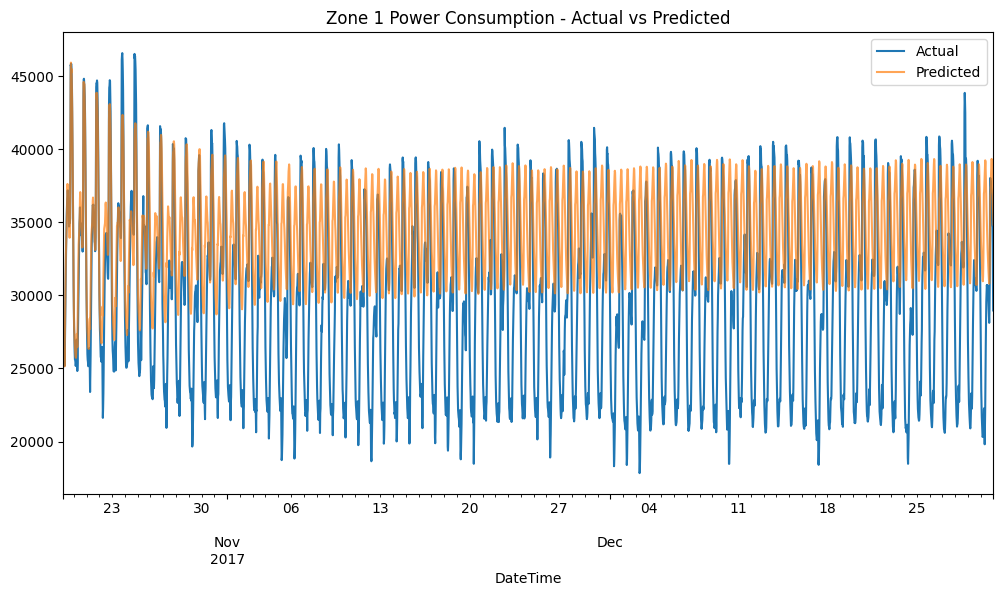

C:\Users\abatl\AppData\Local\Temp\ipykernel_26784\2131367075.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  train=dataset_train_fe.resample('30T').mean(),
C:\Users\abatl\AppData\Local\Temp\ipykernel_26784\2131367075.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  test=dataset_test_fe.resample('30T').mean(),


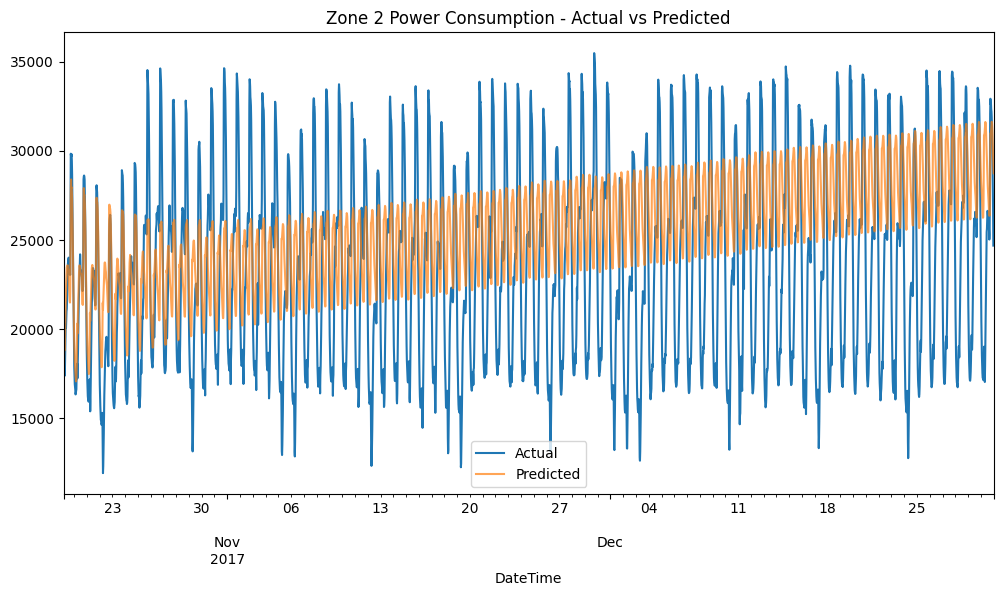

C:\Users\abatl\AppData\Local\Temp\ipykernel_26784\2131367075.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  train=dataset_train_fe.resample('30T').mean(),
C:\Users\abatl\AppData\Local\Temp\ipykernel_26784\2131367075.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  test=dataset_test_fe.resample('30T').mean(),


KeyError: "['is_business_hours'] not in index"

In [ ]:
# Define features for each zone based on correlation
zone_features = {
    'Zone 1 Power Consumption': ['Temperature', 'Humidity', 'is_weekend'],
    'Zone 2 Power Consumption': ['Temperature', 'Wind Speed'],
    'Zone 3 Power Consumption': ['Wind Speed']
}

# Run models
results = {}
for zone in zone_features:
    metrics, model = correct_sarimax(
        zone=zone,
        train=dataset_train_fe.resample('30T').mean(),
        test=dataset_test_fe.resample('30T').mean(),
        exog_vars=zone_features[zone]
    )
    
    if metrics:
        results[zone] = metrics
        # Create DataFrame with actual and predicted values
        results_df = pd.DataFrame({
            'actual': metrics['actual'],
            'predicted': metrics['predicted']
        })

        # Save to CSV
        results_df.to_csv(f'{zone}_actual_vs_predicted.csv')
        # Plot results
        plt.figure(figsize=(12, 6))
        metrics['actual'].plot(label='Actual')
        metrics['predicted'].plot(label='Predicted', alpha=0.7)
        plt.title(f'{zone} - Actual vs Predicted')
        plt.legend()
        plt.show()
        

# Print final metrics
print("\nFinal Metrics:")
for zone, res in results.items():
    print(f"\n{zone}:")
    print(f"RMSE: {res['rmse']:.2f}")
    print(f"MAE: {res['mae']:.2f}")
    print(f"R²: {res['r2']:.2f}")